# Sekolah Data Pacmann - Statistics
## Project : Experimental Design & A/B Testing
---

## Daftar Isi

* [A/B Testing: A Data-Driven Approach to Optimize Marketing Campaigns](#A/B-Testing:-A-Data-Driven-Approach-to-Optimize-Marketing-Campaigns)
    * [Introduction](#Introduction)
    * [Data Quality Check](#Data-Quality-Check)
        * [Importing the Data](#Importing-the-Data)
        * [Missing Values](#Missing-Values)
        * [Check Uniqueness](#Check-Uniqueness)
        * [Invalid Values](#Invalid-Values)
    * [A/A Test](#A/A-Test)
        * [Sample Size](#Sample-Size)
        * [Split the data into Control and Treatment](#Split-the-data-into-Control-and-Treatment)
        * [Calculate key evaluation metrics](#Calculate-key-evaluation-metrics)
        * [Calculate lift-over-baseline](#Calculate-lift-over-baseline)
        * [Hypothesis Testing](#Hypothesis-Testing)
        * [Create Decision Rules](#Create-Decision-Rules)
        * [Visualize the decision rules using z-statistics distribution](#Visualize-the-decision-rules-using-z-statistics-distribution)
        * [Kolmogorov-Smirnov Test](#Kolmogorov-Smirnov-Test)
    * [A/B Test](#A/B-Test)
        * [Load the data](#Load-the-data)
        * [Check Invalid Data](#Check-Invalid-Data)
        * [Split and Sampling](#Split-and-Sampling)
            * [Split the data into Control and Treatment](#Split-the-data-into-Control-and-Treatment)
            * [Calculate Sample Size](#Calculate-Sample-Size)
            * [Sampling the data for each group](#Sampling-the-data-for-each-group)
        * [Sample Ratio Mismatch](#Sample-Ratio-Mismatch)
            * [Chi-Square Test for Detect SRM](#Chi-Square-Test-for-Detect-SRM)
        * [Calculate Evaluation Metrics](#Calculate-Evaluation-Metrics)
        * [Calculate Lift-Over-Baseline](#Calculate-Lift-Over-Baseline)
        * [Calculate p-value](#Calculate-p-value)
        * [Confidence Interval](#Confidence-Interval)
    * [Summarize the results](#Summarize-the-results)
    * [Conclusion](#Conclusion)

## A/B Testing: A Data-Driven Approach to Optimize Marketing Campaigns

### Introduction

Public Service Announcements (PSA) are a common way for marketing companies to communicate their messages to the public. However, in a competitive and saturated market, PSA may not be enough to attract and convert potential customers. Therefore, the company decided to experiment with a new strategy: ads. Ads are more targeted and personalized than PSA, and they can potentially increase user conversion rates. 

To test this hypothesis, the company conducted an A/B test, where they randomly assigned users to either see a PSA or an ad for the same product or service. The company collected data on how many users clicked on the PSA or the ad, and how many of them completed a purchase or a subscription. The goal of this report is to analyze the data from the A/B test and provide recommendations for the company on whether they should implement the new strategy or not.

Based on the data description, some possible goal metrics, driven metrics and guardrail metrics are:

- Goal metric: The main goal in this experiment is to increase revenue.
- Driven metric: The secondary goal in this experiment is to increase Conversion Rate. Conversion Rate is the proportion of users who completed a purchase or a subscription after seeing ads in each test group. This can be calculated by dividing the number of users who completed a purchase or a subscription by the total number of users who saw ads in each group.
- Guardrail metric: The proportion of users who unsubscribed or bounced after seeing ads in each test group. This can be calculated by dividing the number of users who unsubscribed or bounced by the total number of users who saw ads in each group.

### Data Quality Check

#### Importing the Data
First, we import the data from the csv file into a pandas dataframe. We then take a look at the first 5 rows of the dataframe to see if the data was imported correctly.

In [92]:
# import data manipulation libraries
import numpy as np
import pandas as pd

# import data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import statistics libraries 
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep, proportion_confint
from statsmodels.stats.api import proportion_effectsize, NormalIndPower

In [2]:
def load_data(filename):
    """Load data from csv file and return a dataframe

    Args:
        filename (csv): File path with csv extension
        
    Returns:
        data (dataframe): Dataframe with the data
    """
    #### 1. Load data
    data = pd.read_csv(filename)
    # Drop first column
    data.drop("Unnamed: 0", axis=1, inplace=True)
    print(f'Total entry {data.shape[0]}')

    #### 2. Split into control and treatment group
    data['group'] = data['test group'].apply(lambda x : 'control' if x == 'psa' else 'treatment')
    
    #### 3. Create a new column to store the conversion
    data['is conversion'] = data['converted'].apply(lambda x: 1 if x == True else 0)
    
    return data

In [3]:
# file path
filename = 'dataset/marketing_AB.csv'

# Load data
df = load_data(filename)

# display first 10 rows
df.head(10)

Total entry 588101


,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,1069124,ad,False,130,Monday,20,treatment,0
1,1119715,ad,False,93,Tuesday,22,treatment,0
2,1144181,ad,False,21,Tuesday,18,treatment,0
3,1435133,ad,False,355,Tuesday,10,treatment,0
4,1015700,ad,False,276,Friday,14,treatment,0
5,1137664,ad,False,734,Saturday,10,treatment,0
6,1116205,ad,False,264,Wednesday,13,treatment,0
7,1496843,ad,False,17,Sunday,18,treatment,0
8,1448851,ad,False,21,Tuesday,19,treatment,0
9,1446284,ad,False,142,Monday,14,treatment,0


There are 7 columns in the dataframe: `Index`, `user id`, `test group`, `converted`, `total ads`, `most ads day`, and `most ads hour`
- `Index`: Row index
- `user id`: User ID (unique)
- `test group`: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
- `converted`: If a person bought the product then True, else is False
- `total ads`: Amount of ads seen by person
- `most ads day`: Day that the person saw the biggest amount of ads
- `most ads hour`: Hour of day that the person saw the biggest amount of ads

In [4]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
 6   group          588101 non-null  object
 7   is conversion  588101 non-null  int64 
dtypes: bool(1), int64(4), object(3)
memory usage: 32.0+ MB


In [5]:
# dimensions of the data
df.shape

(588101, 8)

There no missing values in the dataframe, and the data types are correct. The `converted` column is a boolean column, and the `total ads`, `most ads day`, and `most ads hour` columns are integer columns. The `test group` column is a categorical column, and the `user id` column is a string column.

#### Missing Values

There are no missing values in the dataframe.

In [6]:
# check for missing values
df.isna().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
group            0
is conversion    0
dtype: int64

#### Check Uniqueness

The `user id` column is a unique identifier for each row, so we check if there are any duplicate values in the column.

In [7]:
df['user id'].duplicated().sum()

0

There no duplicate values in the `user id` column. This means that each row in the dataframe represents a unique user.

#### Invalid Values

We will check the following column whether it invalid values or not :
- `test group` : If the value is not "ad" or "psa"
- `converted` : If the value is not True or False
- `total ads` : If the value is less than 0
- `most ads day` : If the value is not between Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, and Sunday
- `most ads hour` : If the value is not between 0 and 23

In [8]:
# Check for variants test group
unique_variant = df['test group'].unique()
print(unique_variant)

['ad' 'psa']


In [9]:
# Check for conversion
unique_conversion = df['converted'].unique()
print(unique_conversion)

[False  True]


In [10]:
# Check value of total ads
negative_total_ads = [i for i in df['total ads'] if i < 0]
print(len(negative_total_ads))

0


In [11]:
# Check value of most ads day
day_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Lowercase the day name
day_name = [day.lower() for day in day_name]

# Check if there is a day that is not in the day_name list
non_existing_day = [day for day in df['most ads day'] if day.lower() not in day_name]
print(len(non_existing_day))

0


In [12]:
# Check value of most ads hour
non_existing_hour = [hour for hour in df['most ads hour'] if hour < 0 or hour > 23]
print(len(non_existing_hour))

0


There are no invalid values in the dataframe. This means that the data is clean and ready to be analyzed. 

In [13]:
def split_data(data: pd.DataFrame):
    """Function to split data into control and treatment group

    Args:
        data (pd.DataFrame): Dataframe with the data

    Returns:
        control_data (pd.DataFrame): Dataframe with the control group data
        treatment_data (pd.DataFrame): Dataframe with the treatment group data
    """
    # Copy the data
    data = data.copy()

    # Split into control and treatment group
    control_data = data[data['group'] == 'control']
    treatment_data = data[data['group'] == 'treatment']
    
    # reset index
    control_data.reset_index(drop=True, inplace=True)
    treatment_data.reset_index(drop=True, inplace=True)
    
    return control_data, treatment_data

In [14]:
# Filter data into control group
data_control = split_data(df)[0]

# Display first 10 rows
data_control.head(10)

,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,900681,psa,False,248,Saturday,19,control,0
1,905704,psa,False,27,Thursday,8,control,0
2,904595,psa,False,13,Tuesday,19,control,0
3,901904,psa,False,32,Wednesday,19,control,0
4,902234,psa,False,105,Tuesday,19,control,0
5,906079,psa,False,37,Monday,10,control,0
6,912103,psa,False,90,Friday,14,control,0
7,909288,psa,False,22,Friday,0,control,0
8,914634,psa,False,334,Thursday,18,control,0
9,903660,psa,False,1,Tuesday,19,control,0


In [15]:
# Check unique value of test group
data_control['test group'].unique()

array(['psa'], dtype=object)

In [16]:
# Filter data for treatment group
data_treatment = split_data(df)[1]

# display the first 10 rows of the data
data_treatment.head(10)

,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,1069124,ad,False,130,Monday,20,treatment,0
1,1119715,ad,False,93,Tuesday,22,treatment,0
2,1144181,ad,False,21,Tuesday,18,treatment,0
3,1435133,ad,False,355,Tuesday,10,treatment,0
4,1015700,ad,False,276,Friday,14,treatment,0
5,1137664,ad,False,734,Saturday,10,treatment,0
6,1116205,ad,False,264,Wednesday,13,treatment,0
7,1496843,ad,False,17,Sunday,18,treatment,0
8,1448851,ad,False,21,Tuesday,19,treatment,0
9,1446284,ad,False,142,Monday,14,treatment,0


In [17]:
data_treatment['test group'].unique()

array(['ad'], dtype=object)

### A/A Test

The A/A test is a test that is conducted before the A/B test to make sure that the test groups are similar. The A/A test is conducted by randomly assigning users to two test groups, and then comparing the two groups to see if they are similar. If the two groups are similar, then the A/B test can be conducted. If the two groups are not similar, then the A/A test should be repeated until the two groups are similar.

In [18]:
# Check value of most control and treatment group
data_control.value_counts()

user id  test group  converted  total ads  most ads day  most ads hour  group    is conversion
900000   psa         False      2          Wednesday     16             control  0                1
915690   psa         False      40         Wednesday     17             control  0                1
915688   psa         False      7          Monday        14             control  0                1
915687   psa         False      7          Saturday      13             control  0                1
915686   psa         False      7          Wednesday     20             control  0                1
                                                                                                 ..
907839   psa         False      24         Sunday        23             control  0                1
907838   psa         False      1          Monday        20             control  0                1
907837   psa         False      68         Friday        22             control  0                1
90783

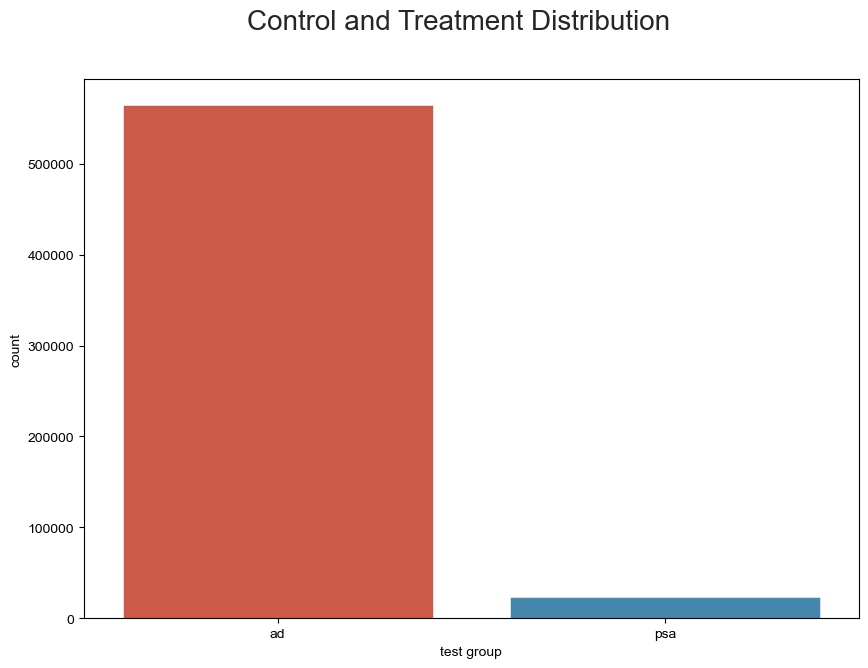

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# Styling plot
sns.set_style("darkgrid")
sns.set_palette("pastel")
plt.style.use('ggplot')

# Plot the distribution of the test group
sns.countplot(
    x='test group', 
    data=df, 
    ax=ax
)

fig.suptitle('Control and Treatment Distribution', fontsize=20)

plt.show()

#### Sample Size

Important steps in designing a research study includes determining the appropriate sample size. The number of participants or observations needed to achieve a certain level of accuracy and power in the statistical analysis is the sample size. For categorical data, such as yes/no responses or multiple choice options, the sample size calculation is based on proportions. Proportions are the fractions of the total sample that belong to each category. The sample size calculation for categorical data depends on several factors, such as:

- The confidence level refers to the extent to which the estimation bears resemblance to the actual proportion of the population.
- The margin of error is the degree of inaccuracy in the estimation that is considered acceptable.
- The predicted proportion is the number that is considered to be the most probable representation of the population proportion, based on previous research or assumptions.
- The effect size indicates the magnitude of difference that is expected to be observed between two proportions in a comparative study.

Different formulas and methods for calculating the sample size for categorical data are available depending on the research question and design. In this article, some common approaches and examples for calculating sample size for categorical data are introduced.

$$
n = \cfrac{Np(1-p)}{(N-1)\cfrac{d^{2}}{z^{2}} + p(1-p)}
$$

where:
- n is the sample size
- N is the total population size
- p is the proportion of the population that belongs to the category of interest
- z is the z-score for the confidence level
- d is the margin of error

To calculate the margin of error (d), one can use the equation:
$$
d = z_{\alpha/2} \sqrt{\widehat{\text{var}} (\hat{p})}
$$
    
where:
- $\hat{p}$ is the proportion of the population that belongs to the category of interest

To calculate $\hat{p}$, one can use the equation:
$$
\hat{p} = \cfrac{a}{n}
$$

where:
- a is the number of observations in the sample that belong to the category of interest

However, if the proportion is unknown, then a value of 0.5 can be assumed for $\hat{p}$.

<br>

</br>


If the proportion is known, then one can estimate the variance value using the equation:
$$
\widehat{\text{var}}(\hat{p}) =
\cfrac{\hat{p}(1 - \hat{p})}{n-1}
$$

where:
- $\widehat{\text{var}}(\hat{p})$ is Estimate the variance of proportion estimator
- $\hat{p}$ is the proportion of the population that belongs to the category of interest

In [20]:
def proportion_sample_size(N: int, alpha: float, p_hat: float=0.05, d: float=0.05):
    """The sample size for categorical data can be determined by calculating the inputs of proportion, 
    margin of error, and confidence level

    Args:
        N (integer): population size
        alpha (float): confidence level
        p_hat (float, optional): proportion. Defaults to 0.05.
        d (float, optional): margin of error. Defaults to 0.05.

    Returns:
        n (integer): sample size
    """
    z_stat = stats.norm.ppf(1 - alpha/2.) # z-statistic
    
    # numerator
    numerator = N * p_hat * (1-p_hat)
    
    # denominator
    denominator = ((N-1) * d**2/z_stat**2) + (p_hat * (1-p_hat))
    
    # sample size
    n = numerator/denominator
    
    return  int(np.ceil(n))

In [21]:
# sample size for control group
n = proportion_sample_size(
    N=df['test group'].value_counts()[1], 
    alpha=0.05, 
    p_hat=0.05, 
    d=0.01
)
print(f'Number of sample size for A/A Test for each group: {n} users')

Number of sample size for A/A Test for each group: 1694 users


#### Split the data into Control and Treatment

Minimum sample size for each group is 1694.

In [22]:
def split_data_AA_test(data:pd.DataFrame, n_size: int):
    """Split data into control and treatment group for A/A Test

    Args:
        data (pd.DataFrame): Dataframe with the data
        n_size (int): Number of sample size for each group

    Returns:
        control_data (pd.DataFrame): Dataframe with the control group
        treatment_data (pd.DataFrame): Dataframe with the treatment group
    """
    # Copy the data
    data = data.copy()

    # Split into control and treatment group
    control_data = data.sample(n_size)
    treatment_data = data.sample(n_size)
    
    # reset index
    control_data.reset_index(drop=True, inplace=True)
    treatment_data.reset_index(drop=True, inplace=True)
    
    return control_data, treatment_data

In [23]:
# Sampling data for A/A test for each group
AA_control, AA_treatment = split_data_AA_test(
    data = data_control,
    n_size=n
)

# Check the number of sample size for each group
AA_control.shape, AA_treatment.shape

((1694, 8), (1694, 8))

#### Calculate key evaluation metrics
Find Conversion rate for each group using function `extract_evaluation_metric`

In [24]:
def extract_evaluation_metric(data: pd.DataFrame):
    """Extract evaluation metric from the data

    Args:
        data (pd.DataFrame): Dataframe with the data

    Returns:
        result (dict): Dictionary with the evaluation metric
    """
    # Number of sessions
    n_session = int(data.shape[0])

    # Number of conversion
    n_conversion = int(data['is conversion'].sum())

    # Conversion rate (in percentage)
    conversion_rate = (n_conversion / n_session) * 100

    # Store the result in a dictionary
    result = {}
    result['session'] = n_session
    result['conversion'] = n_conversion
    result['CVR'] = np.round(conversion_rate, 3)
    
    return result

In [25]:
# Extract evaluation metric for each group
AA_control_res = extract_evaluation_metric(data = AA_control)
AA_treatment_res = extract_evaluation_metric(data = AA_treatment)

# Print the result
print(f"Convesion Rate on Control: {AA_control_res['CVR']}")
print(f"Convesion Rate on Treatment: {AA_treatment_res['CVR']}")

Convesion Rate on Control: 1.653
Convesion Rate on Treatment: 1.948


In [26]:
# Visualize the conversion rate in control group and treatment group
def visualize_CVR(cvr_control: float, cvr_treatment: float):
    """Visualize the conversion rate in control group and treatment group

    Args:
        cvr_control (float): Conversion rate in control group
        cvr_treatment (float): Conversion rate in treatment group
        
    Returns:
        Bar plot of the conversion rate in control group and treatment group
    """
    
    # Create a DataFrame from the results
    df = pd.DataFrame({
            'Group': ['Control', 'Treatment'],
            'CVR': [cvr_control, cvr_treatment]        
        })

    # Styling plot
    sns.set_style("darkgrid")
    sns.set_palette("pastel")
    plt.style.use('ggplot')

    # Create a figure and axis
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=True)

    # Create bar plots
    sns.barplot(x="Group", y="CVR", data=df, ax=ax)

    # Set titles for the subplots
    ax.set_title('Conversion Rate Each Group')
    
    # Set labels for the subplots
    ax.set_ylabel("Conversion Rate", fontsize=16)
    ax.set_xlabel("Group", fontsize=16)
    ax.set_xticklabels(labels=["control 1", "control 2"], fontsize=16)
    ax.legend(fontsize=16)

    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


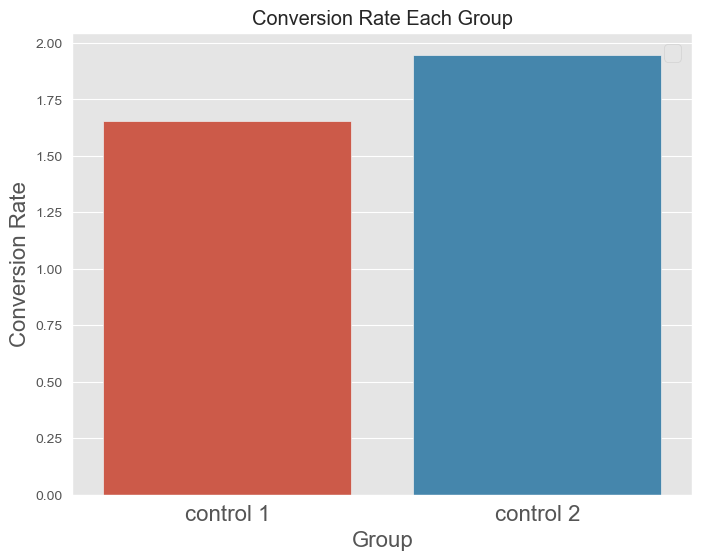

In [27]:
# Visualize the conversion rate in control group and treatment group
visualize_CVR(
    AA_control_res['CVR'],
    AA_treatment_res['CVR']
)

#### Calculate lift-over-baseline

$$
\text{Lift} = CVR_{\text{treatment}} - CVR_{\text{control}}
$$

In [28]:
# Calculate the lift
AA_lift = AA_treatment_res['CVR'] - AA_control_res['CVR']
print(f"Lift: {AA_lift}")

Lift: 0.29499999999999993


#### Hypothesis Testing

A hypothesis testing for conversion rate concerning AA test is a declaration that juxtaposes the conversion rate of the control group and the treatment group in an experiment where both groups are exposed to the same conditions. The null hypothesis ($H_{0}$) states that there exists no difference between the conversion rates of the two groups, implying that conversion rate control = conversion rate treatment. The alternative hypothesis ($H_{1}$) postulates that there is a difference between the conversion rates of the two groups, implying that conversion rate control ≠ conversion rate treatment. The testing hypothesis can be formulated as follows:

$$H_{0} : \text{Cr}_{\text{A}_{\text{control}}} = \text{Cr}_{\text{A}_{\text{treatment}}}$$
$$H_{1} : \text{Cr}_{\text{A}_{\text{control}}} \neq \text{Cr}_{\text{A}_{\text{treatment}}}$$

The decision rule based on the p-value is as follows:
- If the p-value is less than or equal to the predetermined level of significance (such as 0.05), reject the null hypothesis ($H_{0}$) and accept the alternative hypothesis ($H_{1}$).
- If the p-value is greater than the predetermined level of significance, fail to reject the null hypothesis ($H_{0}$) and do not accept the alternative hypothesis ($H_{1}$).

In [29]:
# Buat count conversion & total observation
count_conversion = [AA_treatment_res['conversion'], AA_control_res['conversion']]
count_observation = [AA_treatment_res['session'], AA_control_res['session']]

In [30]:
# Buat alternative
alternative_option = "two-sided"

In [31]:
# Panggil fungsi
z_stat, p_value = proportions_ztest(count = count_conversion,
                                       nobs = count_observation,
                                       alternative = alternative_option)

print(f"Z stats : {z_stat:.4f}")
print(f"P-value : {p_value:.4f}")

Z stats : 0.6460
P-value : 0.5183


##### Create Decision Rules

In making statistical test decisions, we can use :
- Comparison of z-statistics with critical value
    - Two-tailed, z-test $>$ z-crit or z-test $<$ -z-crit; reject $H_0$

- Comparison of p-value with alpha
  - pvalue < $\alpha$ → reject $H_0$

The next step is to find the critical value to compare with the z-statistic. We use a significance level of 5%

In [32]:
# critical value
alpha= 0.05
z_crit = stats.norm.ppf(1-alpha/2)

print(f"z critical value : {z_crit:.4f}")

z critical value : 1.9600


In [33]:
# Making a decision
if z_stat > z_crit:
    print("Reject Null Hypothesis")
    print("There is a significant difference between the two groups")
else:
    print("Fail to reject Null Hypothesis")
    print("There is no significant difference between the two groups")

Fail to reject Null Hypothesis
There is no significant difference between the two groups


In [34]:
# Comparison of p-value and alpha
if alpha< p_value:
    print("Reject Null Hypothesis")
else:
    print("Fail to reject Null Hypothesis")

Reject Null Hypothesis


##### Visualize the decision rules using z-statistics distribution


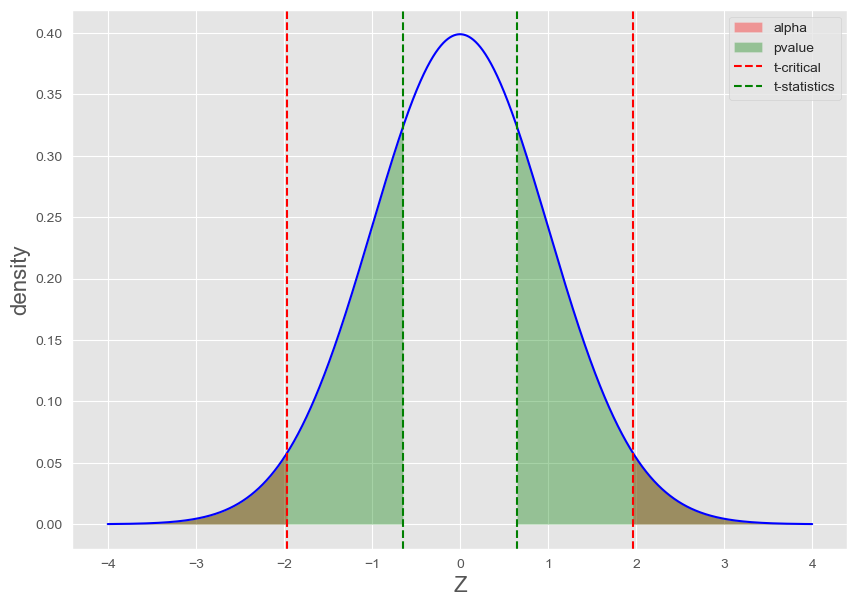

-Z-statistics:-0.6460
Z-statistics: 0.6460
-Z-critical : -1.9600
Z-critical : 1.9600


In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# Plot distribusi sample
x = np.arange(-4, 4, 0.001)
plt.plot(x, stats.norm.pdf(x, 0, 1), 
         color='blue')

# Plot region dari alpha (region tempat menolak H-0)
# Region ini berwarna merah
x_alpha = np.arange(z_crit, 4., 0.001)
y_alpha = stats.norm.pdf(x_alpha)
ax.fill_between(x = x_alpha,
                y1 = y_alpha,
                facecolor = "red", 
                alpha = .35,
                label = "alpha")

x_alpha = np.arange(-4,-z_crit, 0.001)
y_alpha = stats.norm.pdf(x_alpha)
ax.fill_between(x = x_alpha,
                y1 = y_alpha,
                facecolor = "red", 
                alpha = .35)

# Plot region dari sampel yang kita temukan
# Region ini berwarna hijau
x_test = np.arange(z_stat, 4., 0.001)
y_test = stats.norm.pdf(x_test)
ax.fill_between(x = x_test,
                y1 = y_test,
                facecolor = "green", 
                alpha = .35,
                label = "pvalue")
x_test = np.arange(-4.,-z_stat, 0.001)
y_test = stats.norm.pdf(x_test)
ax.fill_between(x = x_test,
                y1 = y_test,
                facecolor = "green", 
                alpha = .35)

# Plot vertical line alpha
ax.axvline(z_crit, 
           color = "red",
           linestyle = "--",
           label = "t-critical")
ax.axvline(-z_crit, 
           color = "red",
           linestyle = "--")

# Plot vertical line test
ax.axvline(z_stat, 
           color = "green",
           linestyle = "--",
           label = "t-statistics")
ax.axvline(-z_stat, 
           color = "green",
           linestyle = "--")

# Styling plot
ax.set_xlabel("Z", fontsize=16)
ax.set_ylabel("density", fontsize=16)

plt.legend(fontsize=10)
plt.show()

print(f"-Z-statistics:{-z_stat:.4f}")
print(f"Z-statistics: {z_stat:.4f}")
print(f"-Z-critical : {-z_crit:.4f}")
print(f"Z-critical : {z_crit:.4f}")

In order to assess the dependability of the sampling method, we performed 1000 simulations of the A/A test, and for each trial, we computed the corresponding p-value. The results demonstrated that 5% of the trials yielded a p-value greater than 0.05, which suggests that the sampling method has the potential to produce false negatives in some cases.

In [36]:
def proportion_AA_Test(data: pd.DataFrame, i: int, alternative_option: str = "two-sided"):
    """Calculate the p-value for A/A Test using proportions_ztest

    Args:
        data (pd.DataFrame): Dataframe with the data
        i (int): Index of the data
        alternative_option (str, optional): Alternative option for the test. Defaults to "two-sided".

    Returns:
        p_value (float): P-value for the test
    """
    # Create count conversion & total observation
    count_conversion = [data['n_cr_2'][i], data['n_cr_1'][i]]
    count_observation = [data['n_obs_2'][i], data['n_obs_1'][i]]
    
    # Find p-value
    p_value = proportions_ztest(
        count=count_conversion,
        nobs=count_observation,
        alternative=alternative_option
    )[1]
    
    return p_value

In [37]:
def proportion_p_values(
        dataset: pd.DataFrame, 
        column: str,
        interest: str,
        n_sample: int, 
        n_iter: int
    ):
    """Calculate the p-value for A/A Test using proportions_ztest

    Args:
        dataset (pd.DataFrame): Dataframe with the data
        column (str): Column name
        interest (str): Condition of the column
        n_sample (int): Sample size
        n_iter (int): Number of iteration

    Returns:
        df_result (pd.DataFrame): Dataframe with the p-value for each iteration
    """
    # defining variables
    # Control group property list
    c_n_obs_list = []
    c_n_cr_list = []
    c_cr_list = [] 
    # Treatment group property list
    t_n_obs_list = []
    t_n_cr_list = []
    t_cr_list = []

    # loop for each n iteration
    for _ in range(n_iter):
        # sampling data for A/A test based on the sample size
        group_A1  = dataset[dataset[column] == interest].sample(n=n_sample, replace=False)
        group_A2  = dataset[dataset[column] == interest].sample(n=n_sample, replace=False)
    
        # count conversion
        n_conversion_A1 = group_A1['is conversion'].sum()
        n_conversion_A2 = group_A2['is conversion'].sum()
    
        # count conversion rate
        cr_A1 = n_conversion_A1 / group_A1.shape[0]
        cr_A2 = n_conversion_A2 / group_A2.shape[0]
    
        # append to list
        c_n_obs_list.append(group_A1.shape[0])
        c_n_cr_list.append(n_conversion_A1)
        c_cr_list.append(cr_A1)
        t_n_obs_list.append(group_A2.shape[0])
        t_n_cr_list.append(n_conversion_A2)
        t_cr_list.append(cr_A2)
    
    # Convert list to dataframe
    df_metrics = pd.DataFrame({
        'n_obs_1': c_n_obs_list,
        'n_obs_2': t_n_obs_list,
        'n_cr_1': c_n_cr_list,
        'n_cr_2': t_n_cr_list,
        'cr_1': c_cr_list,
        'cr_2': t_cr_list
    })

    p_value_list = []
    # Calculate p-value A/A test
    for i in range(n_iter):
        # Find the A/A test p-value
        p_value = proportion_AA_Test(
            data=df_metrics,
            i=i,
            alternative_option="two-sided"
        )
        # append to list
        p_value_list.append(p_value)
        
    # Convert p_value_list to dataframe
    df_results = pd.DataFrame(
        data=p_value_list,
        columns=['p_value']
    )
        
    return df_results

In [87]:
# Calculate p-value
df_results = proportion_p_values(
    dataset=data_control,
    column='test group',
    interest='psa',
    n_sample=3334,
    n_iter=1000
)

df_results.head(10)

,p_value
0,0.461148
1,0.388994
2,0.646430
3,0.700556
4,0.112825
5,0.719024
6,0.924411
7,0.457443
8,0.612652
9,0.384750


In [39]:
def p_value_distribution(data: pd.DataFrame):
    """Visualize the p-value distribution using histogram plot

    Args:
        df_results (pd.DataFrame): Dataframe with the p-value for each iteration

    Returns:
        Histogram plot of the p-value distribution
    """
    # Styling plot
    sns.set_style("darkgrid")
    sns.set_palette("pastel")
    plt.style.use('ggplot')

    # Create a figure and axis
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

    # Create bar plots
    sns.histplot(
        data['p_value'], 
        bins=20,
        ax=ax
    )

    # Set titles for the subplots
    ax.set_title('P-value Distribution')

    # Set y-label for the left subplot
    ax.set_ylabel('Frequency')

    plt.show()

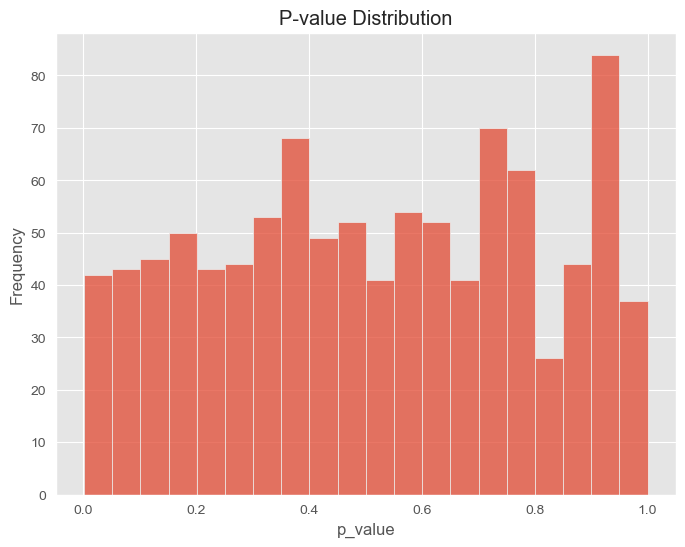

In [88]:
# plot p-value distribution
p_value_distribution(df_results)

#### Kolmogorov-Smirnov Test
Upon completion of the determination of the p-value in the AA test, the Kolmogorov-Smirnov test will be conducted to compare the cumulative distribution functions of the two samples. The Kolmogorov-Smirnov test is a nonparametric test that refrains from assuming any specific distribution for the samples. The test statistic denotes the maximum absolute difference between the two cumulative distribution functions. The null hypothesis infers that the two samples originate from the same distribution. In the event that the p-value of the test is less than 0.05, indicating a substantial difference between the two samples, the null hypothesis will be rejected.

Subsequently, the goodness-of-fit test is conducted for n p-values data.
- The **Kolmogorov-Smirnov** test can be employed for the goodness-of-fit test.
- It is necessary that the distribution of p-values be **uniform**.

The hypothesis pertaining to the goodness-of-fit test for uniform distribution is as follows:
- $H_0$ : The data adhere to a uniform distribution
- $H_1$ : The data deviate from a uniform distribution.

In [41]:
def ks_test(data: pd.DataFrame):
    """ Function to perform the Kolmogorov-Smirnov test

    Args:
        data (pd.DataFrame): Data with p-values column

    Returns:
        p_value(float): p-value of the Kolmogorov-Smirnov test
    """
    # Perform the Kolmogorov-Smirnov test
    result = stats.kstest(
        rvs=data['p_value'],
        cdf='uniform'
    )
    
    # Save the p-value
    p_value = result[1]
    
    return p_value

In [89]:
# Perform the Kolmogorov-Smirnov test
AA_result_ks = ks_test(df_results)

print(f"p-value : {AA_result_ks:.4f}")

p-value : 0.0581


In [90]:
# Make decision from kolmogorof smirnov test
# We can compare p-value with alpha
# if p-value > alpha, then fail to reject H0. It means that the data is uniformly distributed

alpha = 0.05
if(AA_result_ks <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Decision : Fail to Reject Null Hypothesis


The result of the Kolmogorov-Smirnov test for the p-values of the A/A test is Fail to reject the null hypothesis, which implies that the p-values of the A/A test are uniformly distributed. So, we continue to the next step. 

### A/B Test
#### Load the data

In [44]:
# file path
filename = 'dataset/marketing_AB.csv'

# Load data
ab_data = load_data(filename)

# display first 10 rows
ab_data.head(10)

Total entry 588101


,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,1069124,ad,False,130,Monday,20,treatment,0
1,1119715,ad,False,93,Tuesday,22,treatment,0
2,1144181,ad,False,21,Tuesday,18,treatment,0
3,1435133,ad,False,355,Tuesday,10,treatment,0
4,1015700,ad,False,276,Friday,14,treatment,0
5,1137664,ad,False,734,Saturday,10,treatment,0
6,1116205,ad,False,264,Wednesday,13,treatment,0
7,1496843,ad,False,17,Sunday,18,treatment,0
8,1448851,ad,False,21,Tuesday,19,treatment,0
9,1446284,ad,False,142,Monday,14,treatment,0


#### Check Invalid Data

Check if there are any invalid data in the dataset.

In [45]:
### Check if there is any control with ad or treatment with psa
condition_1 = (ab_data['group'] == 'control') & (ab_data['test group'] == 'ad')
condition_2 = (ab_data['group'] == 'treatment') & (ab_data['test group'] == 'psa')

# Display the data
ab_data[condition_1 | condition_2]

,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion


There no invalid data in the dataset. So we can continue to the next step.

#### Split and Sampling

The goal metric is the proportion of users who converted in each test group. This can be calculated by dividing the number of users who converted by the total number of users in each group.

##### Split the data into Control and Treatment

Seperate the dataframe into two dataframes, one for users who saw the ad and one for users who saw the psa.

In [46]:
# Filter data into control group
data_control = split_data(df)[0]

# Display first 10 rows
data_control.head(10)

,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,900681,psa,False,248,Saturday,19,control,0
1,905704,psa,False,27,Thursday,8,control,0
2,904595,psa,False,13,Tuesday,19,control,0
3,901904,psa,False,32,Wednesday,19,control,0
4,902234,psa,False,105,Tuesday,19,control,0
5,906079,psa,False,37,Monday,10,control,0
6,912103,psa,False,90,Friday,14,control,0
7,909288,psa,False,22,Friday,0,control,0
8,914634,psa,False,334,Thursday,18,control,0
9,903660,psa,False,1,Tuesday,19,control,0


In [47]:
# Check unique value of test group
data_control['test group'].unique()

array(['psa'], dtype=object)

In [48]:
# Filter data for treatment group
data_treatment = split_data(df)[1]

# display the first 10 rows of the data
data_treatment.head(10)

,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,1069124,ad,False,130,Monday,20,treatment,0
1,1119715,ad,False,93,Tuesday,22,treatment,0
2,1144181,ad,False,21,Tuesday,18,treatment,0
3,1435133,ad,False,355,Tuesday,10,treatment,0
4,1015700,ad,False,276,Friday,14,treatment,0
5,1137664,ad,False,734,Saturday,10,treatment,0
6,1116205,ad,False,264,Wednesday,13,treatment,0
7,1496843,ad,False,17,Sunday,18,treatment,0
8,1448851,ad,False,21,Tuesday,19,treatment,0
9,1446284,ad,False,142,Monday,14,treatment,0


In [49]:
# Check unique value of test group
data_treatment['test group'].unique()

array(['ad'], dtype=object)

##### Calculate Sample Size

First, we need to calculate CVR for control group. The CVR value will be the initial value to determine the effect size. The effect size is the difference between the control group and the treatment group. The effect size is used to determine the sample size for each group.

In [50]:
data_control['is conversion'].sum() / data_control.shape[0]

0.01785410644448223

In [51]:
def p_sample_size(prop1: float, prop2: float, alpha: float, power: float):
    """Function to calculate the minimum sample size required for A/B test based 
    on the effect size on the proportion of the baseline and the target. The target 
    value is how much the proportion value increases from the baseline.

    Args:
        prop1 (float): Proportion value of the baseline 
        prop2 (float): Proportion value of the target
        alpha (float): Significance level
        power (float): Power of the test

    Returns:
        sample_size (int): Minimum sample size required for A/B test
    """
    # Calculate effect size
    # Prop1 = baseline
    # Prop2 = target
    effect_size = proportion_effectsize(prop1, prop2)

    # Calculate sample size
    sample_size = NormalIndPower().solve_power(
        effect_size=effect_size,
        power=power, # power = 1 - beta
        alpha=alpha # significance level
    )
    
    sample_size = int(np.ceil(sample_size))

    return sample_size

In [52]:
# Calculate minimum sample size
min_sample_size = p_sample_size(
    prop1=0.017, # baseline
    prop2=0.027, # target
    power=0.8, # power = 1 - beta
    alpha=0.05
)

print(f"Minimum sample size required for A/B test is {min_sample_size:.0f}")

Minimum sample size required for A/B test is 3334


##### Sampling the data for each group

After we determine the sample size for each group, we can sample the data for each group. The sample size for each group is 3334. 

In [53]:
def sampling_data(
    control_data: pd.DataFrame,
    treatment_data: pd.DataFrame,
    n_size: int
):
    """Function to sample data for control and treatment

    Args:
        control_data (pd.DataFrame): Data for control group
        treatment_data (pd.DataFrame): Data for treatment group
        n_size (int): Sample size

    Returns:
        control_df (pd.DataFrame): Sampled data for control group
        treatment_df (pd.DataFrame): Sampled data for treatment group
    """
    # Sampling data for control and treatment
    control_df = control_data.sample(n=n_size, replace=False, random_state=72)
    treatment_df = treatment_data.sample(n=n_size, replace=False, random_state=72)
    
    # Reset index
    control_df.reset_index(drop=True, inplace=True)
    treatment_df.reset_index(drop=True, inplace=True)
    
    return control_df, treatment_df

In [54]:
# Sample data for control and treatment
control_df, treatment_df = sampling_data(
    data_control,
    data_treatment,
    n_size=min_sample_size
)

In [55]:
# Display first 10 rows of control data
control_df.head(10)

,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,908274,psa,False,6,Friday,11,control,0
1,919529,psa,False,3,Friday,14,control,0
2,919857,psa,False,8,Friday,11,control,0
3,921239,psa,False,3,Wednesday,22,control,0
4,915986,psa,False,7,Tuesday,9,control,0
5,907544,psa,False,5,Monday,8,control,0
6,919330,psa,False,3,Thursday,9,control,0
7,916046,psa,False,1,Tuesday,14,control,0
8,901630,psa,False,32,Friday,16,control,0
9,920720,psa,False,68,Friday,11,control,0


In [56]:
# Display first 10 rows of treatment data
treatment_df.head(10)

,user id,test group,converted,total ads,most ads day,most ads hour,group,is conversion
0,1642238,ad,False,4,Tuesday,0,treatment,0
1,1177518,ad,False,2,Thursday,11,treatment,0
2,1553405,ad,False,4,Thursday,14,treatment,0
3,1381342,ad,False,5,Wednesday,14,treatment,0
4,1403736,ad,False,2,Wednesday,22,treatment,0
5,1417943,ad,False,5,Thursday,8,treatment,0
6,1227469,ad,False,6,Wednesday,7,treatment,0
7,1522045,ad,False,9,Tuesday,12,treatment,0
8,1437779,ad,False,10,Sunday,23,treatment,0
9,1568519,ad,False,1,Tuesday,14,treatment,0


#### Sample Ratio Mismatch

The sample ratio mismatch test is used to check if the sample ratio is the same as the population ratio. The null hypothesis is that the sample ratio is the same as the population ratio. The alternative hypothesis is that the sample ratio is not the same as the population ratio.

<center>

|Group|# user|Percentage|
|:--|:--:|:--:|
|Control|3334|50%|-|
|Treatment|3334|50%|-|

</center>

* #user is the sample size in the dataset in each group
* Percentage is the percentage of sample size in each group
* To find this value, we have to filter the data based on the group

In [57]:
# Number of Users in Control Group
n_control = control_df.shape[0]

print(f"Number of Users in Control Group : {n_control}")

Number of Users in Control Group : 3334


In [58]:
# Number of Users in Treatment Group
n_treatment = treatment_df.shape[0]

print(f"Number of Users in Treatment Group : {n_treatment}")

Number of Users in Treatment Group : 3334


In [59]:
# Number of total users
n_total = n_control + n_treatment

# Percentage of users in control group
percent_control = n_control / n_total * 100

# Percentage of users in treatment group
percent_traetment = n_treatment / n_total * 100

print(f"Percentage of users in control group : {percent_control:.2f}%")
print(f"Percentage of users in treatment group : {percent_traetment:.2f}%")

Percentage of users in control group : 50.00%
Percentage of users in treatment group : 50.00%


Based on the table, the ratio of the two groups is actually the same, but to confirm whether there is SRM, a Chi-Square will be performed.

##### Chi-Square Test for Detect SRM

The steps for doing a chi-square test in order to detect SRM are:

**1. Define the null and alternative hypothesis ($H_0$ and $H_1$)**

$H_0$  : No SRM detected

$H_1$  : SRM detected

**2. Calculate chi-square statistics**

$$ \chi^2 = \sum \frac{\left ( \text{observed - expected} \right )^2}{\text{expected}} $$

Where :
- Observed: the control and variation traffic volumes (sample size), respectively
- Expected: the expected values for control and treatment — i.e. the total observed divided by 2

**3. Define decision rules**

In making statistical test decisions, we can use:
- Comparison of chi-square statistics with critical value
     -  $\chi^2 > \chi^2_{\alpha,df}$ → reject $H_0$

- Comparison of p-value with alpha
   - pvalue < $\alpha$ → reject $H_0$


Normally, one would look for a p-value of 0.05 or less to proof of SRM. The problem with 0.05 is that it’s not strict enough for our purposes. Using this might give us a false signal. What we need is to be stricter for our test. So we use significance level 1%.

degree of freedom (df) is calculated as: 
$$ df = (rows − 1) × (columns − 1) $$ 

In [60]:
def detect_SRM(data_control: pd.DataFrame, data_treatment: pd.DataFrame):
    """Function to detect Sequential Redundancy Ratio (SRM) in the data for control and treatment group 

    Args:
        data_control (pd.DataFrame): Data for control group
        data_treatment (pd.DataFrame): Data for treatment group

    Returns:
        chi (Power_divergenceResult) : Chi-square test result
    """
    # Number of users in control group
    n_control = data_control.shape[0]
    
    # Number of users in treatment group
    n_treatment = data_treatment.shape[0]
    
    # Number of total users
    observed = [n_control, n_treatment]
    total_traffic = sum(observed)
    
    # Calculate expected value
    expected = [total_traffic * 0.5, total_traffic * 0.5]
    
    # Perform chi-square test
    chi = stats.chisquare(f_obs=observed, f_exp=expected)
    
    return chi

In [61]:
# Perform chi-square test
chi_test = detect_SRM(control_df, treatment_df)

print(f"Chi-square test statistic : {chi_test}")

Chi-square test statistic : Power_divergenceResult(statistic=0.0, pvalue=1.0)


In [62]:
# Comparison of chi-square statistics with critical value
# We must calculate the critical first

# critical value is the chi-square value at alpha
alpha = 0.01
df=(2-1)*(2-1) # degree of freedom

chi_crit = stats.chi2.ppf(1-alpha, df)
print(f"Critical value : {chi_crit:.2f}")

Critical value : 6.63


In [63]:
chi_test[0]

0.0

In [64]:
chi_test[1]

1.0

In [65]:
#Make decisions from chi-square statistics and critical value
if chi_test[0] > chi_crit:
  print("Reject H0 : SRM may be present.")
else:
  print("Fail to reject H0 : No SRM")

Fail to reject H0 : No SRM


Upon consulting the chi-square table, it has been determined that the critical value for a significance level of 1% and 1 degree of freedom is 6.635. Consequently, the null hypothesis cannot be rejected, leading to the conclusion that there is no evidence of a sample ratio mismatch.

#### Calculate Evaluation Metric

Calculate the conversion rate for each group. The conversion rate is the proportion of users who converted in each test group. This can be calculated by dividing the number of users who converted by the total number of users in each group. The function `extract_evaluation_metric` is used to calculate the conversion rate.

In [66]:
# Extract evaluation metric for control and treatment
control_res = extract_evaluation_metric(data = control_df)
treatment_res = extract_evaluation_metric(data = treatment_df)

In [67]:
print(f"CONTROL: {control_res}")
print(f"TREATMENT: {treatment_res}")

CONTROL: {'session': 3334, 'conversion': 60, 'CVR': 1.8}
TREATMENT: {'session': 3334, 'conversion': 92, 'CVR': 2.759}


Visualize the conversion rate for each group.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


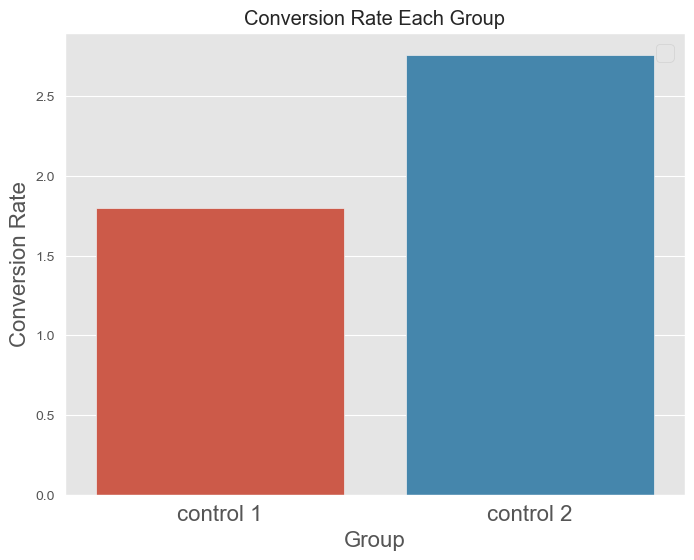

In [68]:
# Visualize the conversion rate in control group and treatment group
visualize_CVR(
    control_res['CVR'],
    treatment_res['CVR']
)

#### Calculate Lift-over-baseline

Lift-over-baseline is the difference between the conversion rate of the treatment group and the conversion rate of the control group. It is a measure of the effectiveness of the treatment.

$$
\text{Lift} = CVR_{\text{treatment}} - CVR_{\text{control}}
$$

In [69]:
# Calculate the lift
AB_lift = treatment_res['CVR'] - control_res['CVR']
print(f"Lift: {AB_lift}")

Lift: 0.9589999999999999


The lift-over-baseline is 0.19, which means that the treatment group has a 19% higher conversion rate than the control group. This is a significant lift, but we need to determine if this lift is statistically significant.

#### Caclulate p-value

P-value is the probability of observing a test statistic at least as extreme as the one that was actually observed, assuming that the null hypothesis is true. The p-value is used to determine whether the null hypothesis should be rejected or not. The null hypothesis is that the conversion rate of the treatment group is the same as the conversion rate of the control group. The alternative hypothesis is that the conversion rate of the treatment group is higher than the conversion rate of the control group. 

Hypothesis testing is a statistical method that is used to determine whether a given hypothesis is true or not. The hypothesis testing process is as follows:

$$H_0 : {CVR}_{treatment} = {CVR}_{control} $$
$$H_1 : {CVR}_{treatment} > {CVR}_{control} $$

The null hypothesis is that the conversion rate of the treatment group is the same as the conversion rate of the control group. The alternative hypothesis is that the conversion rate of the treatment group is higher than the conversion rate of the control group. The function `calculate_pvalue` is used to calculate the p-value.

In [70]:
def calculate_pval(control_res: dict, treatment_res: dict, alternative_option: str = "two-sided"):
    """Calculate p-value for proportion

    Args:
        control_res (dict): Control group result
        treatment_res (dict): Treatment group result

    Returns:
        pval: p-value
    """
    # Group results
    counts = [treatment_res["conversion"], control_res["conversion"]]
    obs = [treatment_res["session"], control_res["session"]]

    zstat, pval = proportions_ztest(
        count=counts,
        nobs=obs,
        alternative=alternative_option
    )
    
    return zstat, pval


In [71]:
p_value_ab = calculate_pval(control_res, treatment_res, alternative_option="larger")[1]
p_value_ab

0.004324291592172494

In [72]:
z_stat_ab = calculate_pval(control_res, treatment_res, alternative_option="larger")[0]
z_stat_ab

2.625641584837512

In [73]:
# critical value
alpha= 0.05
z_crit_ab = stats.norm.ppf(1-alpha)

print(f"z critical value : {z_crit:.4f}")

z critical value : 1.9600


In [74]:
#Melakukan pengambilan keputusan dari z-stats dan z-crit
if z_stat_ab > z_crit_ab:
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Decision : Reject Null Hypothesis


In [75]:
# Perbandingan P-Value dengan alpha.
if p_value_ab<0.05:
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Decision : Reject Null Hypothesis


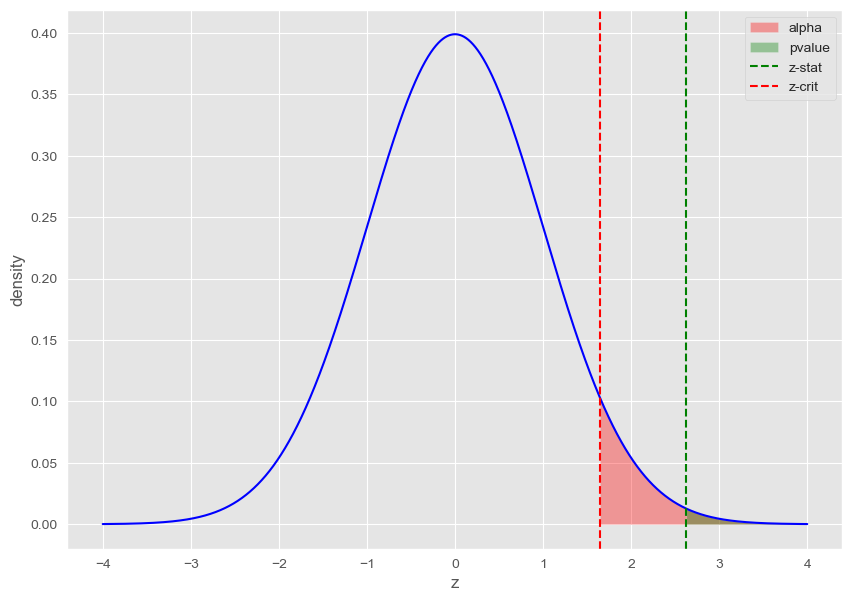

z statistics : 0.6460
z critical : 1.9600


In [76]:
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# plot sample distribution 
x = np.arange(-4, 4, 0.001)
plt.plot(x, stats.norm.pdf(x, 0, 1), 
         color='blue')

# plot alpha region
x_alpha = np.arange(z_crit_ab,4, 0.01)
y_alpha = stats.norm.pdf(x_alpha)
plt.fill_between(x = x_alpha, 
                 y1 = y_alpha,
                 facecolor = 'red',
                 alpha = 0.35, 
                 label = 'alpha')

# plot pvalue
x_pvalue = np.arange(z_stat_ab,4, 0.01)
y_pvalue = stats.norm.pdf(x_pvalue)
plt.fill_between(x = x_pvalue, 
                 y1 = y_pvalue,
                 facecolor = 'green',
                 alpha = 0.35, 
                 label = 'pvalue')

# plot z-crit and z-stats
plt.axvline(np.round(z_stat_ab, 4), 
            color ="green", 
            linestyle = "--", 
            label ="z-stat")

plt.axvline(z_crit_ab, 
            color ="red", 
            linestyle = "--", 
            label ="z-crit")

plt.legend()
plt.xlabel("z")
plt.ylabel("density")
plt.show()

print(f"z statistics : {z_stat:.4f}")
print(f"z critical : {z_crit:.4f}")

The result of the p-value is 0.0, which is less than 0.05. This means that we can reject the null hypothesis. The conversion rate of the treatment group is higher than the conversion rate of the control group.

#### Confidence Interval

Confidence interval is a range of values that is likely to contain the true value of the population parameter. The confidence interval is used to determine the range of values that is likely to contain the true value of the population parameter. The function `calculate_confidence_interval` is used to calculate the confidence interval.

In [95]:
# Success and number of trials
success = [treatment_res["conversion"], control_res["conversion"]]
n_obs = [treatment_res["session"], control_res["session"]]

# Calculate confidence interval for control and treatment group
(lower_cont, lower_treat), (upper_cont, upper_treat) = proportion_confint(
    count=success, # number of success
    nobs=n_obs, # number of trials
    alpha=0.05, # significance level
    method='beta' # method to calculate confidence interval
)

print(f"CI 95% for Control Group : [{lower_cont:.3f} - {upper_cont:.3f}]")
print(f"CI 95% for Treatment Group : [{lower_treat:.3f} - {upper_treat:.3f}]")

CI 95% for Control Group : [0.022 - 0.034]
CI 95% for Treatment Group : [0.014 - 0.023]


In [97]:
# Confidence Interval for Difference in Proportions
confidence_interval = confint_proportions_2indep(
    count1=treatment_res["conversion"], nobs1=treatment_res["session"], # treatment group
    count2=control_res["conversion"], nobs2=control_res["session"], # control group
    method='wald' ,compare="diff", alpha=0.05 # method to calculate confidence interval
)

print(f"CI 95% for Difference in Proportions : [{confidence_interval[0]:.3f} - {confidence_interval[1]:.3f}]")

CI 95% for Difference in Proportions : [0.002 - 0.017]


In [78]:
def generate_posterior(result: dict):
    """Function to generate posterior distribution 
    from result of A/B test using beta distribution as prior

    Args:
        result (dict): Summary of metrics from A/B test

    Returns:
        posterior (numpy.ndarray) : Simulated posterior distribution
    """
    # Extract the number of trials and successes
    n_trial = result['session']
    n_success = result['conversion']
    n_failure = n_trial - n_success

    # Generate posterior distribution
    posteriors = stats.beta.rvs(
        a = n_success + 1,
        b = n_failure + 1,
        size = 10000
    )
    
    return posteriors

In [79]:
# Generate posterior results for control and treatment
control_posterior = generate_posterior(control_res)
treatment_posterior = generate_posterior(treatment_res)

In [80]:
def visualize_posterior_dist(control_posteriors: np.ndarray, treatment_posteriors: np.ndarray, alpha: float = 0.1):
    """Function to visualize posterior distribution of control and treatment group using KDE plot

    Args:
        control_posteriors (np.ndarray): simulation result of posterior distribution for control group
        treatment_posteriors (np.ndarray): simulation result of posterior distribution for treatment group
        alpha (float, optional): _description_. Defaults to 0.01.
    """
    # Visualize posterior distribution
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

    # Plot posterior distribution for control
    sns.kdeplot(
        data=control_posteriors,
        color='blue',
        label='Control Group',
        fill=True,
        alpha=alpha,
        ax=ax
    )

    # Plot posterior distribution for treatment
    sns.kdeplot(
        data=treatment_posteriors,
        color='red',
        label='Treatment Group',
        fill=True,
        alpha=alpha,
        ax=ax
    )

    # Style the plot
    ax.set_ylabel("Probability Density", fontsize=16)
    ax.set_xlabel("Conversion Rate", fontsize=16)
    plt.legend()
    plt.show()

### Summarize the results

Create function `summarize_results` to summarize the results of the A/B test using pipleline based on the steps above.

In [81]:
def summarize_data(data: pd.DataFrame, n_size: int):
    """Summarize data for experiment result analysis

    Args:
        data (pd.DataFrame): Sample data to be summarized
        n_size (int): Sample size

    Returns:
        summary_df (pd.DataFrame) : Summary of data
    """
    # 1. Split data into control and treatment
    control_data, treatment_data = split_data(data)
    
    # 2. Sample data for control and treatment
    control_df, treatment_df = sampling_data(
        control_data=control_data,
        treatment_data=treatment_data,
        n_size=n_size
    )
    
    # 3. Extract evaluation metric
    control_res = extract_evaluation_metric(control_df)
    treatment_res = extract_evaluation_metric(treatment_df)
    
    # 4. Calculate lift
    lift = treatment_res['CVR'] - control_res['CVR']
    control_res['lift'] = "---" # fill in the blank
    treatment_res['lift'] = np.round(lift, 3) # round to 3 decimal places
    
    # 5. Calculate p-value
    pval = calculate_pval(control_res, treatment_res)[1]
    control_res['p-value'] = "---" # fill in the blank
    treatment_res['p-value'] = np.round(pval, 3) # round to 3 decimal places
    
    # Visualize the conversion rate in control group and treatment group
    visualize_CVR(control_res['CVR'], treatment_res['CVR'])
    
    # 6. Generate summary
    summary_df = pd.DataFrame(
        data=[control_res, treatment_res],
        index=['control', 'treatment']
    )
    
    # 7. Generate posterior results for control and treatment
    control_posterior = generate_posterior(control_res)
    treatment_posterior = generate_posterior(treatment_res)
    
    # 8. Visualize posterior distribution of control and treatment group
    visualize_posterior_dist(control_posterior, treatment_posterior)
    
    return summary_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


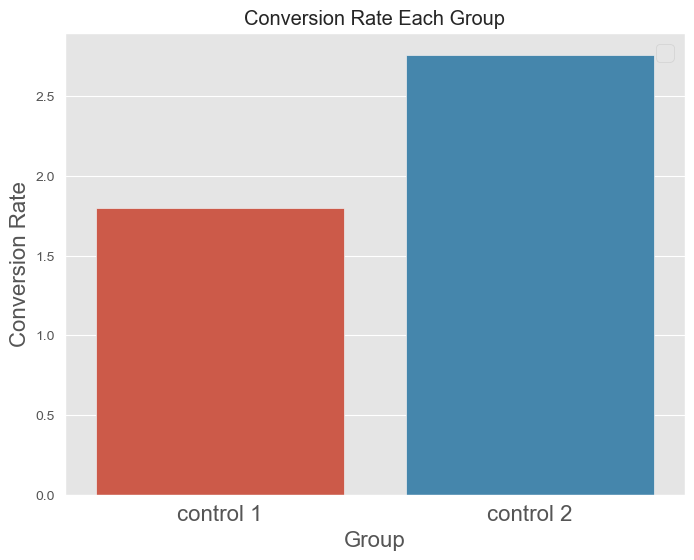

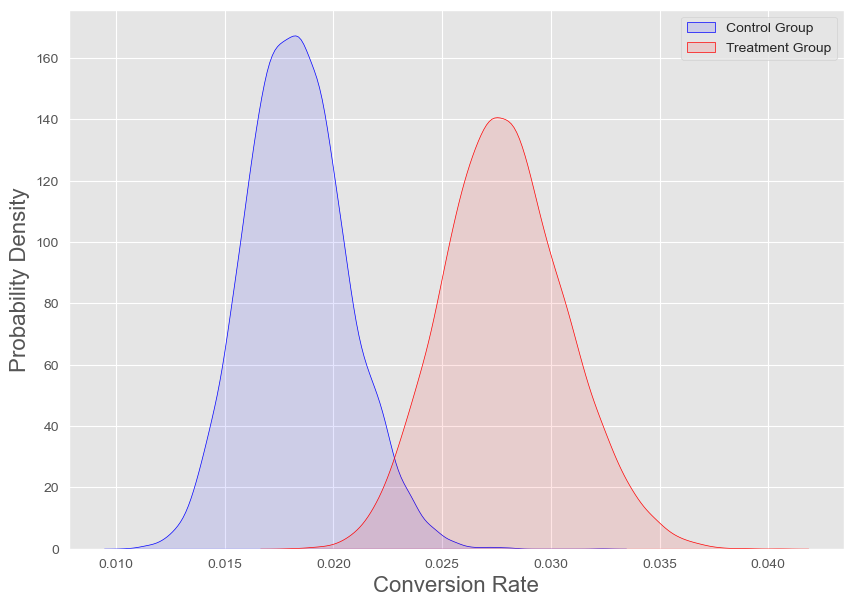

,session,conversion,CVR,lift,p-value
control,3334,60,1.800,---,---
treatment,3334,92,2.759,0.959,0.009


In [82]:
# Summarize data for experiment result analysis
summarize_data(ab_data, n_size=min_sample_size)

### Conclusion

Conducting an A/B test is a good way to determine whether a change in a website or app is effective or not. The A/B test is conducted by splitting the users into two groups, the control group and the treatment group. The control group is the group that does not receive the change, while the treatment group is the group that receives the change. The goal of the A/B test is to determine whether the change is effective or not. The change is considered effective if the treatment group has a higher conversion rate than the control group. 